In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.fft
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sdeint
from toolbox import (
    make_loss,
    StatLoss,
    SINN,
    FPU
)

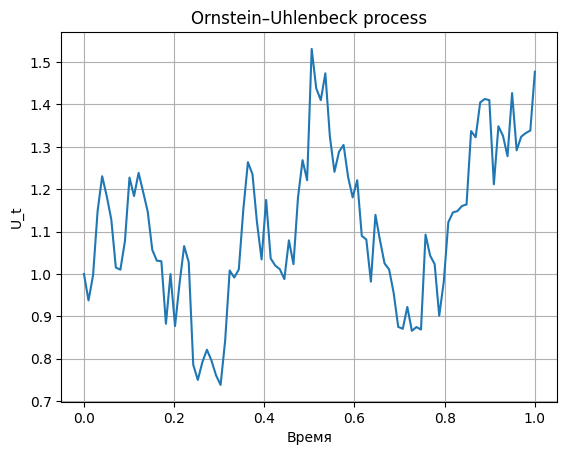

In [3]:
#моделирование процесса OU

theta = 1.0
mu_t = 0
sigma = 1.0
T = 1
dt = 0.01
Wt = 0
iterations = int(T / dt)
X = np.zeros(iterations)
X[0] = 1

for i in range(iterations-1):
  Wt = np.sqrt(dt) * np.random.normal()
  X[i+1] = X[i] + theta * (mu_t - X[i]) * dt + sigma * Wt

t = np.linspace(0, T, iterations)

plt.plot(t, X)
plt.title("Ornstein–Uhlenbeck process")
plt.xlabel("Время")
plt.ylabel("U_t")
plt.grid()
plt.show()

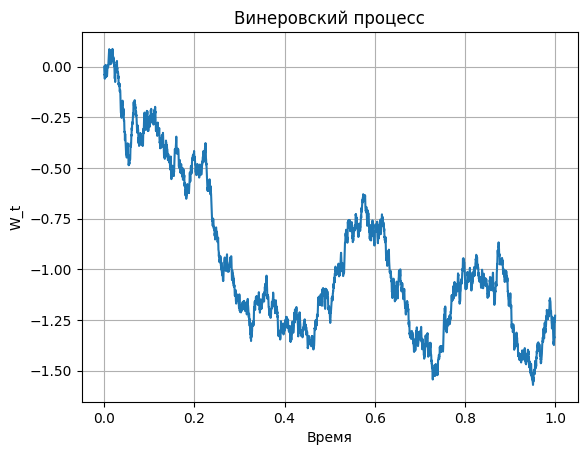

In [ ]:
#Моделирование Винеровского процесса

T = 1.0
iterations = 3000
dt = T / iterations
t = np.linspace(0, T, iterations+1)

W = np.zeros(iterations+1)
for i in range(1, iterations+1):
    W[i] = W[i-1] + np.sqrt(dt) * np.random.normal()


plt.plot(t, W)
plt.title("Винеровский процесс")
plt.xlabel("Время")
plt.ylabel("W_t")
plt.grid()
plt.show()


In [ ]:
!pip install torch sdeint

In [ ]:
# check out SINN model from repo
!git clone https://github.com/SINN-model/SINN.git
!cp SINN/toolbox . -r

(2001, 200)


(1500, 200)
(400, 200) (400, 200)
CPU times: user 659 ms, sys: 0 ns, total: 659 ms
Wall time: 658 ms


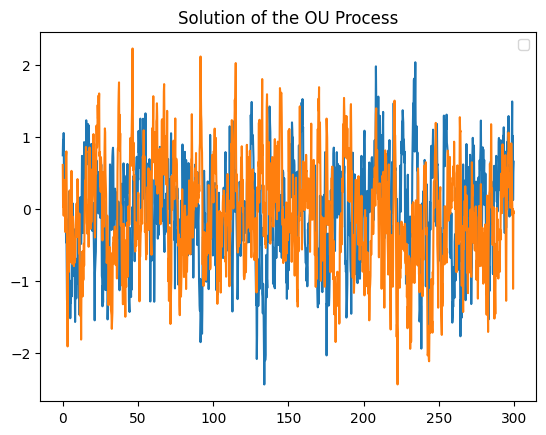

In [ ]:
%%time

#### Parameters for OU process
theta = 1              # Strength of the restoring force
sigma = 1.0              # Noise strength
dt = 0.01
mu_t = 0
delta_t = 0.2
batch = 200
sec_length = 400

#### Time settings
Time = 5 * delta_t * sec_length
length = int(Time / dt) + 1
t = np.linspace(0, Time, length)  # define time axis
gap = int(delta_t / dt)
t_store = t[0:-1:gap]
q_store = np.zeros([t_store.size + 1, batch])
print(q_store.shape)

#### Initialize the process
q0 = np.zeros((1, batch))
q1 = np.zeros((1, batch))

#### OU process solver (Euler-Maruyama scheme)
j = 0
for i in range(1, length):
    Wt = np.random.normal(0, np.sqrt(dt), size=(1, batch))
    q1 = q0 + theta * (mu_t - q0) * dt + sigma * Wt
    if i % gap == 0:
        q_store[j, :] = q1
        j = j + 1
    q0 = q1

#### Cut the initial transient
Toss = int(t_store.size / 4)
q_store = q_store[Toss:-1, :]
print(q_store.shape)

#### Plot sample trajectories
plt.figure(1)
for i in range(2):
    plt.plot(t_store[Toss:] - t_store[Toss], q_store[:, i])
plt.legend()
plt.title("Solution of the OU Process")

# Construct the sample trajectories for SINN learning
ini = np.random.normal(0, 1, (sec_length, batch))
Traj = q_store[0:sec_length, :]
T = np.arange(len(Traj[:, 1])) * delta_t
print(ini.shape, Traj.shape)
x = np.linspace(0, 10, sec_length)


In [ ]:
device = torch.device('cuda')

In [ ]:
# Reformulating data into Torch tensors
# Input of SINN should be of the form (seq_len, batch, input_size)

ini=np.random.normal(0, 1,(2*sec_length,batch)).astype(np.float32)
input = torch.from_numpy(ini.reshape(2*sec_length, batch,1)).to(device)

batch_validation = batch
val=np.random.normal(0, 1,(2*sec_length,batch_validation)).astype(np.float32)
val_set = torch.from_numpy(val.reshape(2*sec_length, batch_validation,1)).to(device)

Traj = Traj.astype(np.float32)
target = torch.from_numpy(Traj.reshape(sec_length, batch,1)).to(device)

print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([800, 200, 1]) torch.float32
The torch validation size is torch.Size([800, 200, 1]) torch.float32
The torch target size is torch.Size([400, 200, 1]) torch.float32


In [ ]:
# Defining Loss functions
LAGS = 400
N = 400
loss_acf_fft = make_loss('acf[fft]', target, lags=LAGS, device=device)
loss_acf_q2 = make_loss('acf[fft]', target**2, lags=LAGS, device=device)
loss_acf_bruteforce = make_loss('acf[bruteforce]', target, lags=LAGS, device=device)
loss_acf_randbrute = make_loss('acf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)
loss_pdf_empirical = make_loss('pdf', target, lower=0, upper=10, n=N, device=device)

/content/toolbox/_loss.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._target = torch.tensor(target, dtype=torch.float32, device=device)


In [ ]:
### Defining SINN model
net = SINN(1, 5, 2, 1).to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [ ]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(5000):
    optimizer.zero_grad()
    ini=np.random.normal(0,1,(2*sec_length,batch)).astype(np.float32)
    input = torch.from_numpy(ini.reshape(2*sec_length, batch,1)).to(device)
    prediction, _ = net(input)
    prediction = prediction[-LAGS:,:,:]
    loss = loss_acf_fft(prediction) + loss_pdf_empirical(prediction) + loss_acf_q2(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0:
        with torch.no_grad():
            pred_val, _ = net(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = loss_acf_bruteforce(pred_val)+ loss_pdf_empirical(pred_val) + loss_acf_q2(pred_val**2)
            loss_val_acf = loss_acf_bruteforce(pred_val)
            print('[%d]-th step loss: %.3f, %.3f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.0005 and loss_val<=0.0005:
            break
print('Training finished')

[0]-th step loss: 0.186, 0.186
[50]-th step loss: 0.160, 0.158
[100]-th step loss: 0.017, 0.017
[150]-th step loss: 0.011, 0.012
[200]-th step loss: 0.007, 0.008
[250]-th step loss: 0.005, 0.005
[300]-th step loss: 0.003, 0.004
[350]-th step loss: 0.003, 0.003
[400]-th step loss: 0.002, 0.002
[450]-th step loss: 0.002, 0.002
[500]-th step loss: 0.002, 0.002
[550]-th step loss: 0.001, 0.002
[600]-th step loss: 0.001, 0.002
[650]-th step loss: 0.001, 0.001
[700]-th step loss: 0.001, 0.001
[750]-th step loss: 0.001, 0.001
[800]-th step loss: 0.001, 0.001
[850]-th step loss: 0.001, 0.001
[900]-th step loss: 0.001, 0.001
[950]-th step loss: 0.001, 0.001
[1000]-th step loss: 0.001, 0.001
[1050]-th step loss: 0.001, 0.001
[1100]-th step loss: 0.000, 0.001
[1150]-th step loss: 0.000, 0.001
[1200]-th step loss: 0.000, 0.001
[1250]-th step loss: 0.000, 0.001
[1300]-th step loss: 0.000, 0.001
[1350]-th step loss: 0.000, 0.001
[1400]-th step loss: 0.000, 0.001
[1450]-th step loss: 0.000, 0.001
[15

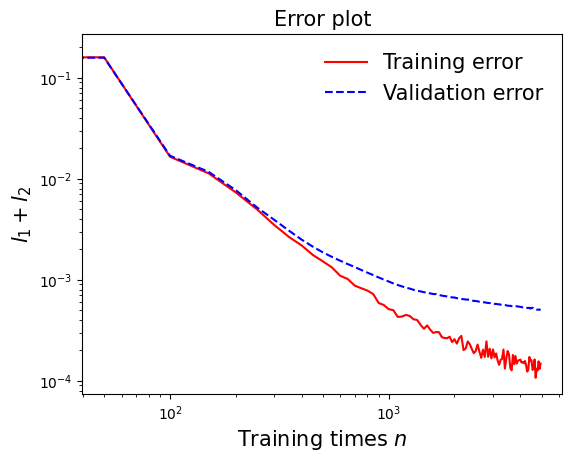

In [ ]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15)
plt.loglog(Step, T_error,'r',label='Training error')
plt.loglog(Step, V_error,'b--',label='Validation error')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/Poisson_training_error.pdf", dpi=150)

In [ ]:
## Normal distributed random input (newly generated)
ran_ini = np.random.normal(0,1,(2*sec_length,batch)).astype(np.float32)
ran_input = torch.from_numpy(ran_ini.reshape(2*sec_length, batch,1)).to(device)
Pred,_= net(ran_input)
prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch)

([<matplotlib.axis.YTick at 0x7a1b4cdff670>,
 [Text(0, -3, '−3'),
  Text(0, -2, '−2'),
  Text(0, -1, '−1'),
  Text(0, 0, '0'),
  Text(0, 1, '1'),
  Text(0, 2, '2'),
  Text(0, 3, '3')])

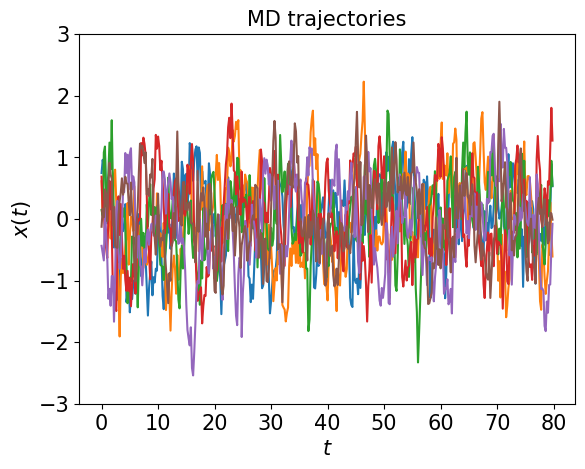

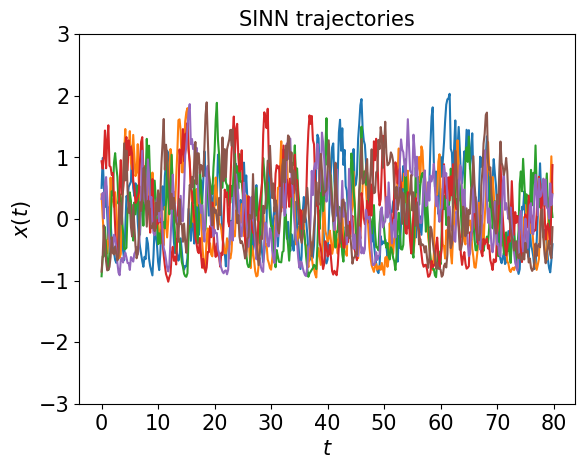

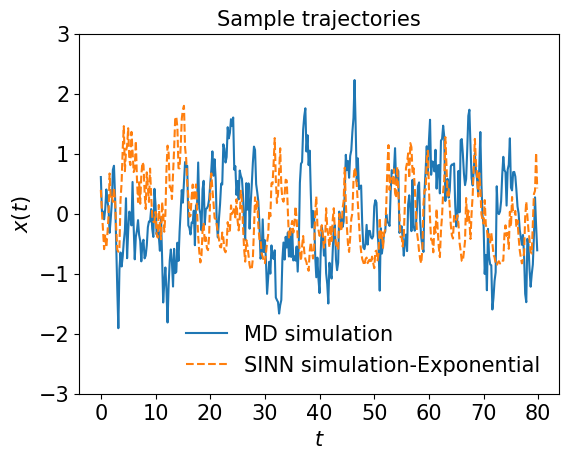

In [ ]:
# Test 1: plot the sample path generated by SINN and the exact sample path
skip = 0

plt.figure(0)
plt.title("MD trajectories",fontsize=15)
plt.plot(T[skip:]-T[skip], Traj[skip:, 0])
plt.plot(T[skip:]-T[skip], Traj[skip:, 1])
plt.plot(T[skip:]-T[skip], Traj[skip:, 2])
plt.plot(T[skip:]-T[skip], Traj[skip:, -1])
plt.plot(T[skip:]-T[skip], Traj[skip:, -2])
plt.plot(T[skip:]-T[skip], Traj[skip:, -3])
plt.ylim([-3,3])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$x(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


plt.figure(1)
plt.title("SINN trajectories",fontsize=15)
plt.plot(T[skip:]-T[skip], prediction[skip:, 0])
plt.plot(T[skip:]-T[skip], prediction[skip:, 1])
plt.plot(T[skip:]-T[skip], prediction[skip:, 2])
plt.plot(T[skip:]-T[skip], prediction[skip:, -1])
plt.plot(T[skip:]-T[skip], prediction[skip:, -2])
plt.plot(T[skip:]-T[skip], prediction[skip:, -3])
plt.ylim([-3,3])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$x(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


fig = plt.figure(2)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Sample trajectories",fontsize=15)
plt.plot(T[skip:]-T[skip], Traj[skip:, 1], label='MD simulation')
plt.plot(T[skip:]-T[skip], prediction[skip:, 1],'--',label='SINN simulation-Exponential')
plt.ylim([-3,3])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$x(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-3, -2, -1, 0,1,2,3],fontsize=15)
# plt.savefig("figs/Poisson_traj.pdf", dpi=150)


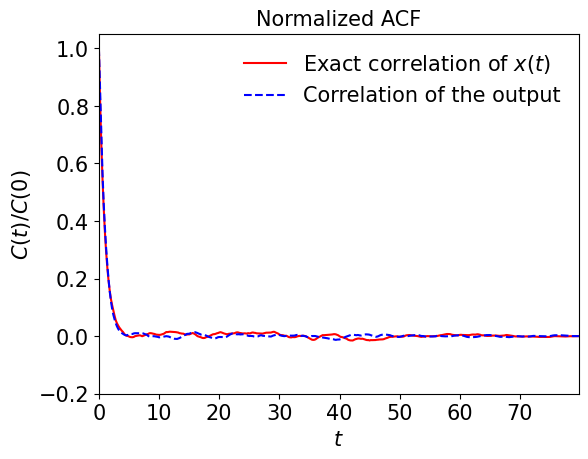

In [ ]:
# Test 2: plot the ACF of the sample path generated by the SINN and the exact ACF

# acf_p=StatLoss.acf(Pred[-sec_length:,:,:],method='bruteforce')
acf_p=StatLoss.acf(Pred[-sec_length:,:,:])
acf_t=StatLoss.acf(target)
corr_p=acf_p.mean(axis=1).detach().cpu().numpy()
corr_t=acf_t.mean(axis=1).detach().cpu().numpy()


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)
plt.plot(T, corr_t,'r',label=r'Exact correlation of $x(t)$')        # correlation function of the target
plt.plot(T, corr_p, 'b--',label=r'Correlation of the output')        # Correlation function after the training      # Correlation function after the training
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.xlim(0,T[-1])
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/Poisson_acf.pdf", dpi=150)





(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0')])

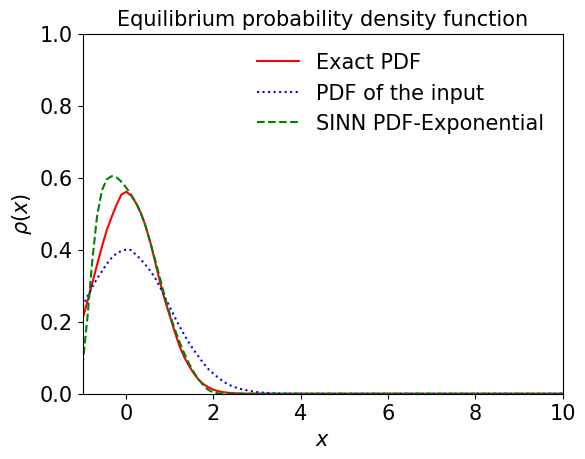

In [ ]:
# Test 3: plot the PDF of the sample path generated by SINN and the exact PDF

rho_data =  StatLoss.gauss_kde(target, -1, 10, 100).cpu()
rho_input = StatLoss.gauss_kde(ran_input, -1, 10, 100).cpu()
rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -1, 10, 100).cpu()


x=np.linspace(-1, 10, 100)
fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r"Equilibrium probability density function",fontsize=15)
plt.plot(x, rho_data.numpy(), 'r',label=r'Exact PDF')    # target PDF
plt.plot(x, rho_input.numpy(), 'b:', label=r'PDF of the input')     # PDF of the input
plt.plot(x, rho_prediction.numpy(), 'g--',label=r'SINN PDF-Exponential')  # PDF after the training
plt.xlim(-1,10)
plt.ylim(0,1)
plt.xlabel(r'$x$',fontsize=15)
plt.ylabel(r'$\rho(x)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("figs/Poisson_pdf.pdf", dpi=150)


# ###### Save the PDF data
# from tempfile import TemporaryFile
# Poisson_PDF_Exponential = TemporaryFile()
# rho_pred_Exp=rho_prediction.numpy()
# np.savez('Poisson_PDF_Exponential.npz', x, rho_pred_Exp)


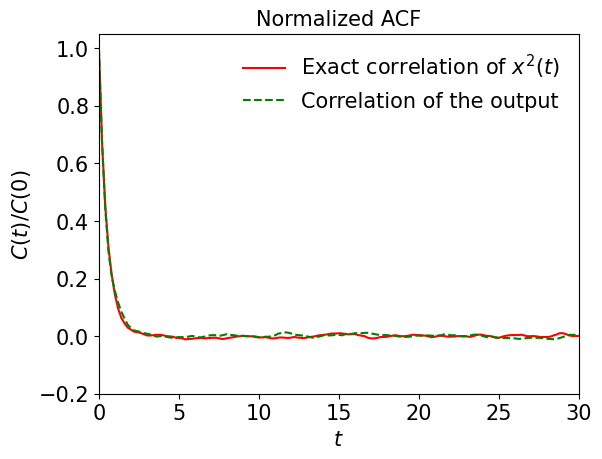

In [ ]:
# Test 4: Comparing the higher-order ACF

acf2=StatLoss.acf(target**2)
pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,1))
acf2_app=StatLoss.acf(pred_norm**2)

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)
plt.plot(T, acf2.mean(axis=1).detach().cpu().numpy(),'r',label=r'Exact correlation of $x^2(t)$')        # Exact correlation function
plt.plot(T, acf2_app.mean(axis=1).detach().cpu().numpy(), 'g--',label=r'Correlation of the output')        # Correlation function after the training
plt.xlim(0,30)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/Poisson_acf2.pdf", dpi=150)




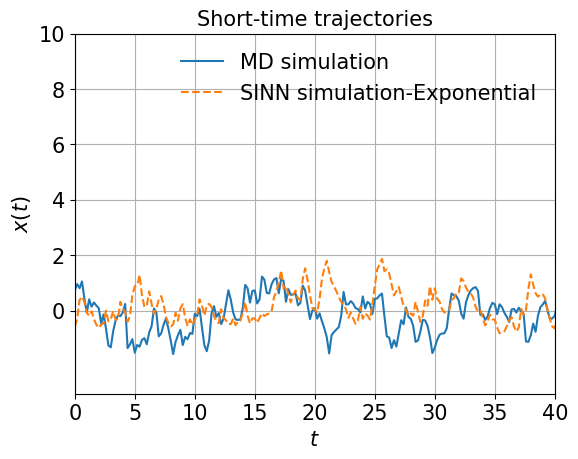

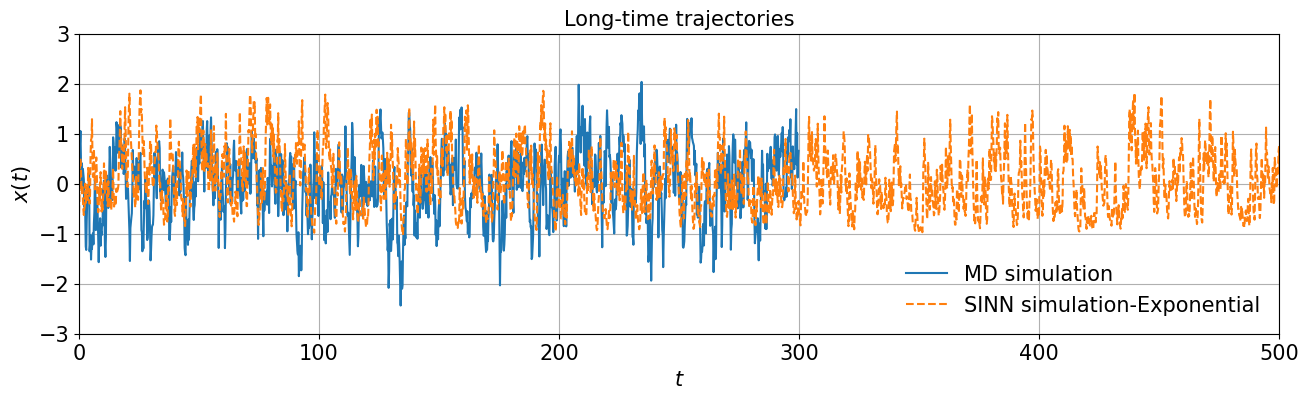

In [ ]:
# Test 5: plot the expolation result, i.e. Prediction of the Poisson SDE for longer time
[a,b,c]=input.size()
skip=20
scale=10
burnin=3
fold=800
batch_new=50

ran_ini = np.random.normal(0,1,((scale-burnin)*a,batch_new,c)).astype(np.float32)
ran_input = torch.from_numpy(ran_ini.reshape((scale-burnin)*a, batch_new,c)).to(device)
Pred_L, _= net(ran_input)
prediction_ext=Pred_L.detach().cpu().numpy().reshape((scale-burnin)*a, batch_new)
acf_p=StatLoss.acf(Pred_L,method='bruteforce')

LT=np.linspace(0,(scale-burnin)*a*delta_t,num=(scale-burnin)*a+1)
LT=LT[0:-1]


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Short-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],q_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 1],'--',label='SINN simulation-Exponential')
plt.xlim([0,40])
plt.ylim([-3,3])
plt.grid(True)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$x(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([0,2,4,6,8,10],fontsize=15)
plt.xticks(fontsize=15)
# plt.savefig("figs/Poisson_traj_sT.pdf", dpi=150)


fig = plt.figure(figsize=(16, 4))
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Long-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],q_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 1],'--',label='SINN simulation-Exponential')
plt.xlim([0,500])
plt.ylim([-3,3])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$x(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-3, -2, -1, 0,1, 2, 3],fontsize=15)
plt.xticks(fontsize=15)
plt.grid(True)
# plt.savefig("figs/Poisson_traj_lT.pdf", dpi=150)



